In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression

import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Читаю свой обработанный фаил

In [85]:
df1 = pd.read_csv(r'D:\Skillfactory\MATH_1\cleaned_and_transformed_data.csv')
df = df1.copy()
df.head()

,status,fireplace,target,beds_clean,sqft_category_encoded,baths_clean,state_0,state_1,state_2,state_3,...,type__mobile manufactured,type__multi family home,type__other,type__single family home,street_type_0,street_type_1,street_type_2,street_type_3,street_type_4,target_log
0,1,1,418000.0,4,3.0,4,0,0,0,0,...,0,0,0,1,0,0,0,0,1,12.943239
1,1,1,399000.0,4,2.0,3,0,0,0,0,...,0,0,0,1,0,0,0,1,0,12.896719
2,0,1,331990.0,2,1.0,2,0,0,0,0,...,0,0,0,1,0,0,0,1,0,12.712863
3,1,1,364990.0,3,3.0,3,0,0,0,0,...,0,0,0,1,0,0,0,0,1,12.807628
4,1,1,320000.0,3,3.0,2,0,0,0,0,...,0,0,0,1,0,0,0,1,1,12.676079


In [86]:
df.shape


(320680, 51)

Все хорошо, идем дольше.

Формируем: 
1. матрицу наблюдений X   
2. вектор целевой переменной y и его логарифм y_log.      
В матрицу наблюдений войдут все столбцы из таблицы с недвижимотью за исключением целевого признака target и его логарифмированной версии target_log:

In [87]:
X = df.drop(['target', 'target_log'], axis=1)
y = df['target']
y_log = df['target_log']


Также добавить стратификауию - потому как у нас малый процент дорогого жилья. нужно сохранить баланс выборок. 
Но➡️ stratify можно использовать только с категориальными или дискретными признаками, а не с непрерывной логарифмированной ценой (y_log).

Так как y_log — непрерывная переменная, нужно сначала разбить её на категории, например, по квантилям. Это создаст категориальную версию, по которой можно стратифицировать.

In [88]:
y_log_strata = pd.qcut(y_log, q=5, labels=False)

# Сплит с учетом стратификации
X_train, X_valid, y_train_log, y_valid_log = train_test_split(
    X, y_log,
    test_size=0.30,
    random_state=42,
    stratify=y_log_strata  # Стратификация по ценовым категориям
)

# Проверка
print("Train:", X_train.shape, y_train_log.shape)
print("Valid:", X_valid.shape, y_valid_log.shape)

Train: (224476, 49) (224476,)
Valid: (96204, 49) (96204,)


У меня 320,680 строк. 
ВЫбираю. Hold-Out валидацию.

Теперь переходим к столбцам. На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


С помощью SelectKBest отботберем 357 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуем по обучающей выборке, используя параметр      
**score_func = f_regression.**



In [89]:
# Инициализируем SelectKBest и применяем отбор признаков
selector = SelectKBest(score_func=f_regression, k=35)
selector.fit(X_train, y_train_log)  # Отбор признаков

# Получаем список отобранных признаков
selected_features = X_train.columns[selector.get_support()]

# Преобразуем обучающую и валидационную выборки с учетом отобранных признаков
X_train_selected = X_train[selected_features]
X_valid_selected = X_valid[selected_features]

In [90]:
print(selected_features)


Index(['status', 'fireplace', 'beds_clean', 'sqft_category_encoded',
       'baths_clean', 'state_1', 'state_2', 'state_3', 'state_4', 'state_5',
       'mean_rating_schools', 'median_distance_schools',
       'total_num_grades_schools', 'heating_electric', 'heating_forced_air',
       'heating_other', 'heating_radiant', 'cooling_central',
       'cooling_unclear_cooling', 'cooling_unit', 'stories_encoded',
       'parking_driveway', 'parking_garage', 'parking_multi_space',
       'parking_other', 'parking_street', 'lot_size_encoded',
       'building_age_encoded', 'type__apartment', 'type__house', 'type__lot',
       'type__mobile manufactured', 'type__multi family home', 'street_type_1',
       'street_type_4'],
      dtype='object')


Отлично!
Заранее позаботимся о масштабировании факторов. 
Я выбрала StandardScaler, так как у нас оставались небольшие выбросы внутри категории по типу недвижимости. 
Чтобы избежать разбалансировки масштабов.

In [91]:
scaler = StandardScaler()
# Обучаем scaler тольько на тренировочных данных
scaler.fit(X_train_selected)

# а применяем трансформацию к train и valid
X_train_scaled_df = scaler.transform(X_train_selected)
X_valid_scaled_df = scaler.transform(X_valid_selected)

#  Преобразуем в DataFrame с сохранением имён колонок
X_train_scaled = pd.DataFrame(X_train_scaled_df, columns=X_train_selected.columns, index=X_train_selected.index)
X_valid_scaled = pd.DataFrame(X_valid_scaled_df, columns=X_valid_selected.columns, index=X_valid_selected.index)


# Решение задачи регрессии

У нас есть целевая переменная числоваяю. Будем строить модель с учителем.

Определим метрику, по которой мы будем измерять качество наших моделей.
RMSLE 

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать цену недвижимости в логарифмическом масштабе:


In [ ]:
# Инициализируем и обучаем базовую модель
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_log)

# Предсказания
y_train_pred = lr_model.predict(X_train_scaled)
y_valid_pred = lr_model.predict(X_valid_scaled)

# RMSLE (на логарифмированной цели)
rmsle_train = np.sqrt(mean_squared_error(y_train_log, y_train_pred))
rmsle_valid = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred))

# Округляем
print("📊 Метрикa (логарифмированная цель):\n ")
print(f"RMSLE на тренировочной выборке:      {rmsle_train:.2f}")
print(f"RMSLE на валидационной выборке:      {rmsle_valid:.2f}\n ")


📊 Метрикa (логарифмированная цель):
 
RMSLE на тренировочной выборке:      0.61
RMSLE на валидационной выборке:      0.61
 


Посчитаем RMSE в обычном масштабе (в долларах) — то есть после обратного преобразования np.exp()

In [93]:
y_train_pred_real = np.exp(y_train_pred)
y_valid_pred_real = np.exp(y_valid_pred)
y_train_real = np.exp(y_train_log)
y_valid_real = np.exp(y_valid_log)

# Метрики в масштабе цен
rmse_train_real = mean_squared_error(y_train_real, y_train_pred_real, squared=False)
rmse_valid_real = mean_squared_error(y_valid_real, y_valid_pred_real, squared=False)

print("\n📊 Метрики в масштабе реальных цен (доллары):\n")
print(f"RMSE на тренировочной выборке:      ${rmse_train_real:,.0f}")
print(f"RMSE на валидационной выборке:      ${rmse_valid_real:,.0f}\n")


📊 Метрики в масштабе реальных цен (доллары):

RMSE на тренировочной выборке:      $293,535
RMSE на валидационной выборке:      $290,481



* В среднем модель отклоняется от реальной цены на ~293 тыс. на обучающей выборке
* На валидации — тоже около ~292 тыс., что говорит об отсутствии переобучения.

Посмотрим на статистические данные по целевой target

In [94]:
df1.target.describe()

count    3.206800e+05
mean     4.001762e+05
std      3.897190e+05
min      1.000000e+04
25%      1.890000e+05
50%      2.999950e+05
75%      4.888880e+05
max      5.360000e+06
Name: target, dtype: float64

* Средняя цена (mean): ~$400,000
* Медиана (50%): ~$300,000
* Макс: $5,360,000

Ошибка в ~292,000 — это много, особенно если учитывать, что половина домов стоят меньше 300,000.
Но — это базовая линейная модель, она не может «гнуться» под сложные зависимости. Это ожидаемо.

Усложним модель. Построим модель полиномиальной регрессии 2-ой степени на обучающей выборке

In [96]:
# 1. Генерация полиномиальных признаков степени 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)

# 2. Обучение модели
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train_log)

# 3. Предсказания
y_train_pred = poly_model.predict(X_train_poly)
y_valid_pred = poly_model.predict(X_valid_poly)

# 4. Метрики (логарифмированная цель)
rmsle_train = np.sqrt(mean_squared_error(y_train_log, y_train_pred))
rmsle_valid = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred))

print("📊 Полиномиальная регрессия (2-я степень):\n")
print(f"RMSLE на тренировочной выборке:     {rmsle_train:.2f}")
print(f"RMSLE на валидационной выборке:     {rmsle_valid:.2f}")


📊 Полиномиальная регрессия (2-я степень):

RMSLE на тренировочной выборке:     0.54
RMSLE на валидационной выборке:     0.54


Как и в прошлый раз переобучение в модели не наблюдается. Но  при этом ошибка стала меньше. 

Добавим к нашей полиномиальной регрессии 2-й степени, L2-регуляризацию (модель Ridge) 

In [ ]:

# Генерация полиномиальных признаков степени 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)

# Инициализация Ridge-регрессии с регуляризацией L2 (α=1)
ridge_model = Ridge(alpha=1)

# Обучение модели
ridge_model.fit(X_train_poly, y_train_log)

# Предсказания
y_train_pred = ridge_model.predict(X_train_poly)
y_valid_pred = ridge_model.predict(X_valid_poly)

# RMSLE (на логарифмированной целевой переменной)
rmsle_train = np.sqrt(mean_squared_error(y_train_log, y_train_pred))
rmsle_valid = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred))

# вывод
print("📊 Полиномиальная регрессия с L2-регуляризацией (α=1):\n")
print(f"RMSLE на тренировочной выборке:     {rmsle_train:.2f}")
print(f"RMSLE на валидационной выборке:     {rmsle_valid:.2f}")

📊 Полиномиальная регрессия с L2-регуляризацией (α=1):

RMSLE на тренировочной выборке:     0.54
RMSLE на валидационной выборке:     0.54


Тот же результат. Попробуем найти оптимальную альфа.

In [ ]:
def tune_ridge_alpha(X_train_scaled, y_train_log, X_valid_scaled, y_valid_log, alpha_list):
    # 1. Генерируем полиномиальные признаки
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_valid_poly = poly.transform(X_valid_scaled)

    best_alpha = None
    best_rmsle = float('inf')
    results = []

    # 2. Перебираем значения alpha
    for alpha in alpha_list:
        model = Ridge(alpha=alpha)
        model.fit(X_train_poly, y_train_log)

        y_valid_pred = model.predict(X_valid_poly)
        rmsle = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred))

        results.append((alpha, rmsle))

        if rmsle < best_rmsle:
            best_rmsle = rmsle
            best_alpha = alpha
            best_model = model

    # 3. Выводим лучшие результаты
    print(f"🔍 Лучшее alpha: {best_alpha}")
    print(f"📉 RMSLE на валидации: {best_rmsle:.4f}")

    return best_model, best_alpha, results,


# Задаём список alpha
alpha_values = [0.01, 0.1, 0.5, 1, 5, 10, 50, 100]

# Запускаем подбор
best_model, best_alpha, ridge_results = tune_ridge_alpha(X_train_scaled, y_train_log, X_valid_scaled, y_valid_log, alpha_values)


🔍 Лучшее alpha: 100
📉 RMSLE на валидации: 0.5416


Не сильно меняется значение от перемены альфы. Поэтому оставляем как есть.

## Перейдем к задачам деревья решений

In [ ]:

# Инициализация модели с параметром random_state
tree_model = DecisionTreeRegressor(random_state=42)

# Обучаем модель на нормализованных данных
tree_model.fit(X_train_scaled, y_train_log)

# Предсказания на тренировочной и валидационной выборках
y_train_pred = tree_model.predict(X_train_scaled)
y_valid_pred = tree_model.predict(X_valid_scaled)

# Рассчитываем метрику RMSLE
rmsle_train = np.sqrt(mean_squared_error(y_train_log, y_train_pred))
rmsle_valid = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred))

# Округляем до двух знаков
rmsle_train = round(rmsle_train, 2)
rmsle_valid = round(rmsle_valid, 2)

# Выводим результаты
print(f"RMSLE на тренировочной выборке: {rmsle_train}")
print(f"RMSLE на валидационной выборке: {rmsle_valid}")


RMSLE на тренировочной выборке: 0.15
RMSLE на валидационной выборке: 0.56


На лицо переобучение. Дерево решений слишком гибкое.
Оно запомнило обучающую выборку почти «наизусть»
А на новых данных (валидации) теряет обобщающую способность.

✅Ищем оптимальную глубину дерева. Диапазон поиска от 4 до 20:
max_depths = range(4, 20)
Сразу построим линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 


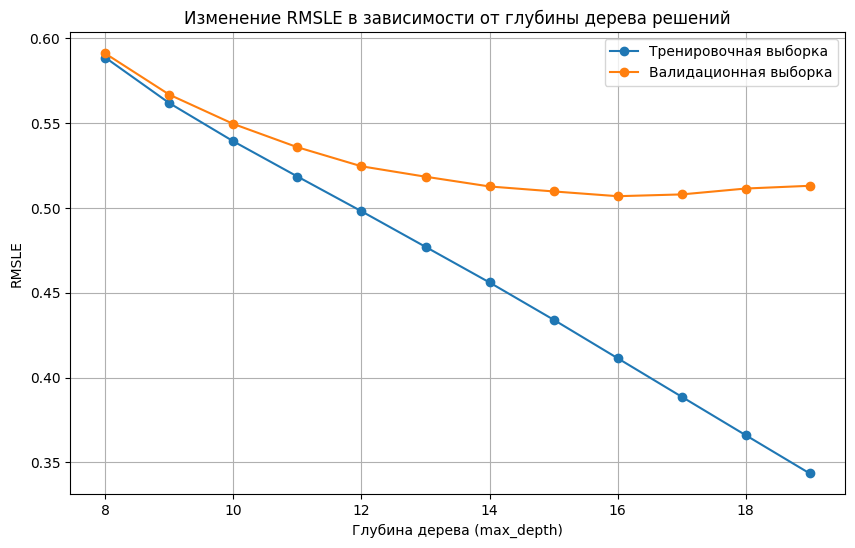

Оптимальная глубина дерева решений: 16


In [ ]:
# Диапазон глубины дерева
max_depths = range(8, 20)

# Списки для хранения результатов
rmsle_train = []
rmsle_valid = []

# Перебор всех значений max_depth
for depth in max_depths:
    # Инициализация модели дерева решений с заданной глубиной
    tree_model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    
    # Обучаем модель
    tree_model.fit(X_train_scaled, y_train_log)
    
    # Предсказания на тренировочной и валидационной выборках
    y_train_pred = tree_model.predict(X_train_scaled)
    y_valid_pred = tree_model.predict(X_valid_scaled)
    
    # Рассчитываем RMSLE
    rmsle_train.append(np.sqrt(mean_squared_error(y_train_log, y_train_pred)))
    rmsle_valid.append(np.sqrt(mean_squared_error(y_valid_log, y_valid_pred)))

# Строим линейные графики для RMSLE на тренировочной и валидационной выборках
plt.figure(figsize=(10, 6))
plt.plot(max_depths, rmsle_train, label='Тренировочная выборка', marker='o')
plt.plot(max_depths, rmsle_valid, label='Валидационная выборка', marker='o')
plt.xlabel('Глубина дерева (max_depth)')
plt.ylabel('RMSLE')
plt.title('Изменение RMSLE в зависимости от глубины дерева решений')
plt.legend()
plt.grid(True)
plt.show()

# Определение оптимальной глубины дерева (первое значение, при котором валидационная ошибка начинает возрастать)
optimal_depth = max_depths[np.argmin(rmsle_valid)]
print(f"Оптимальная глубина дерева решений: {optimal_depth}")


In [ ]:
# Инициализация модели с параметром random_state
tree_model = DecisionTreeRegressor(max_depth=16, random_state=42)

# Обучаем модель на нормализованных данных
tree_model.fit(X_train_scaled, y_train_log)

# Предсказания на тренировочной и валидационной выборках
y_train_pred = tree_model.predict(X_train_scaled)
y_valid_pred = tree_model.predict(X_valid_scaled)

# Рассчитываем метрику RMSLE
rmsle_train = np.sqrt(mean_squared_error(y_train_log, y_train_pred))
rmsle_valid = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred))

# Округляем до двух знаков
rmsle_train = round(rmsle_train, 2)
rmsle_valid = round(rmsle_valid, 2)

# Выводим результаты
print(f"RMSLE на тренировочной выборке: {rmsle_train}")
print(f"RMSLE на валидационной выборке: {rmsle_valid}")

RMSLE на тренировочной выборке: 0.41
RMSLE на валидационной выборке: 0.51


Сбалансировались лучше выборки. Попробую добавить еще параметров и прогнать их  через Optuna

In [118]:
import optuna
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

def dt_objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0, 0.01),
        'random_state': 42
    }
    model = DecisionTreeRegressor(**params)
    model.fit(X_train_scaled, y_train_log)
    preds = model.predict(X_valid_scaled)
    return np.sqrt(mean_squared_error(y_valid_log, preds))

# 1) Запускаем оптимизацию
study_dt = optuna.create_study(direction='minimize')
study_dt.optimize(dt_objective, n_trials=30)

print("📌 Лучшие параметры (DT Optuna):")
print(study_dt.best_params)

# 2) Обучаем финальную модель
best_dt = DecisionTreeRegressor(**study_dt.best_params, random_state=42)
best_dt.fit(X_train_scaled, y_train_log)

# 3) Считаем и выводим RMSLE
y_train_pred = best_dt.predict(X_train_scaled)
y_valid_pred = best_dt.predict(X_valid_scaled)

rmsle_train = np.sqrt(mean_squared_error(y_train_log, y_train_pred))
rmsle_valid = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred))

print(f"\n🔹 RMSLE train (лог): {rmsle_train:.4f}")
print(f"🔹 RMSLE valid (лог): {rmsle_valid:.4f}")


[I 2025-07-08 12:02:05,611] A new study created in memory with name: no-name-dfd72798-afe5-4322-a4c3-59b6fcd23333
[I 2025-07-08 12:02:14,669] Trial 0 finished with value: 0.5491105538000077 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'ccp_alpha': 0.008030611050025142}. Best is trial 0 with value: 0.5491105538000077.
[I 2025-07-08 12:02:14,847] Trial 1 finished with value: 0.5880536546869037 and parameters: {'max_depth': 11, 'min_samples_split': 47, 'min_samples_leaf': 14, 'max_features': 'log2', 'ccp_alpha': 0.004376244054205735}. Best is trial 0 with value: 0.5491105538000077.
[I 2025-07-08 12:02:15,087] Trial 2 finished with value: 0.5711958555685962 and parameters: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'ccp_alpha': 0.007793501565298533}. Best is trial 0 with value: 0.5491105538000077.
[I 2025-07-08 12:02:15,303] Trial 3 finished with value: 0.5694655199869567 and parameters:

📌 Лучшие параметры (DT Optuna):
{'max_depth': 19, 'min_samples_split': 35, 'min_samples_leaf': 17, 'max_features': None, 'ccp_alpha': 2.557382736144534e-05}

🔹 RMSLE train (лог): 0.4226
🔹 RMSLE valid (лог): 0.4727


Удивительно. Лучшие параметры по глубине по  Optuna и по графику выше отличаются.
В общем, с дополнительными параметрами + автоматически подогнаными, результат стал намного лучше.
и самое главное,  разница на тренировочной и валидационной выборках  очень маленькая.


### Перейдем к моделям посложнее.

#### Начнем с случайных деревьев. Сразу выполню поиск параметрам по gridsearch.

In [ ]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Сетка параметров для Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [12, 16, 20],
    'min_samples_split': [2, 10],
    'max_features': ['sqrt', 'log2', None]
}

# Инициализируем модель
rf = RandomForestRegressor(random_state=42, criterion='squared_error')

# GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=rmsle_scorer,
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Обучение
grid_search_rf.fit(X_train_scaled, y_train_log)

# Лучшая модель
best_rf = grid_search_rf.best_estimator_

# Предсказания
y_train_pred = best_rf.predict(X_train_scaled)
y_valid_pred = best_rf.predict(X_valid_scaled)

# RMSLE
rmsle_train = np.sqrt(mean_squared_error(y_train_log, y_train_pred))
rmsle_valid = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred))

# Округление
print("🔍 Лучшие параметры:", grid_search_rf.best_params_)
print(f"\nRMSLE на тренировочной выборке:     {rmsle_train:.2f}")
print(f"RMSLE на валидационной выборке:     {rmsle_valid:.2f}")


Fitting 3 folds for each of 36 candidates, totalling 108 fits
🔍 Лучшие параметры: {'max_depth': 20, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 200}

RMSLE на тренировочной выборке:     0.30
RMSLE на валидационной выборке:     0.43


Прогоним параметры через Optuna. 

In [ ]:
# Функция цели для Optuna (минимизируем RMSLE в лог‑пространстве)
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'max_depth': trial.suggest_int('max_depth', 12, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42,
        'n_jobs': -1
    }
    model = RandomForestRegressor(**params)
    model.fit(X_train_scaled, y_train_log)
    preds = model.predict(X_valid_scaled)
    return np.sqrt(mean_squared_error(y_valid_log, preds))

# Запускаем оптимизацию
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(rf_objective, n_trials=30)

print(" Лучшие параметры (RF Optuna):")
print(study_rf.best_params)

# Обучаем финальную модель на лучших параметрах
best_rf = RandomForestRegressor(**study_rf.best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train_scaled, y_train_log)

# Расчёт RMSLE на train/valid
y_train_pred = best_rf.predict(X_train_scaled)
y_valid_pred = best_rf.predict(X_valid_scaled)

rmsle_train = np.sqrt(mean_squared_error(y_train_log, y_train_pred))
rmsle_valid = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred))

print(f"\n🔹 RMSLE train (лог): {rmsle_train:.4f}")
print(f"🔹 RMSLE valid (лог): {rmsle_valid:.4f}")


[I 2025-07-08 03:02:29,370] A new study created in memory with name: no-name-c63ce184-04a5-4986-9b4a-9dd1b6278647
[I 2025-07-08 03:02:33,805] Trial 0 finished with value: 0.47286663545516605 and parameters: {'n_estimators': 128, 'max_depth': 12, 'min_samples_split': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.47286663545516605.
[I 2025-07-08 03:02:38,153] Trial 1 finished with value: 0.4711842737818434 and parameters: {'n_estimators': 127, 'max_depth': 12, 'min_samples_split': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.4711842737818434.
[I 2025-07-08 03:02:44,528] Trial 2 finished with value: 0.4629896299852885 and parameters: {'n_estimators': 172, 'max_depth': 13, 'min_samples_split': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.4629896299852885.
[I 2025-07-08 03:02:49,694] Trial 3 finished with value: 0.45658542619924236 and parameters: {'n_estimators': 129, 'max_depth': 13, 'min_samples_split': 8, 'max_features': 'sqrt'}. Best is trial 3 wi

 Лучшие параметры (RF Optuna):
{'n_estimators': 180, 'max_depth': 19, 'min_samples_split': 7, 'max_features': None}

🔹 RMSLE train (лог): 0.2908
🔹 RMSLE valid (лог): 0.4328


Примерно в том же диапазоне. 

#### Построим модель GradientBoostingRegressor 
Начнем с поиска параметров gridsearch

In [ ]:
# RMSLE scorer
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Сетка гиперпараметров
param_grid = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}

# GridSearch
grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    scoring=rmsle_scorer,
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Обучение
grid_search.fit(X_train_scaled, y_train_log)

# Лучшая модель
best_gb = grid_search.best_estimator_

# Предсказания
y_train_pred = best_gb.predict(X_train_scaled)
y_valid_pred = best_gb.predict(X_valid_scaled)

# Метрики
rmsle_train = np.sqrt(mean_squared_error(y_train_log, y_train_pred))
rmsle_valid = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred))


# Вывод
print(" Лучшие параметры:", grid_search.best_params_)
print("\n Метрики (логарифмированная цель):")
print(f" RMSLE на тренировочной выборке: {rmsle_train:.2f}")
print(f"RMSLE на валидационной выборке: {rmsle_valid:.2f}")



Fitting 3 folds for each of 16 candidates, totalling 48 fits
📌 Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}

📊 Метрики (логарифмированная цель):
✅ RMSLE на тренировочной выборке: 0.50
✅ RMSLE на валидационной выборке: 0.50


Теперь прогоним параметры через Optuna

In [ ]:
# Objective-функция для Optuna
def gb_objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
     'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),
        'random_state': 42
    }
    model = GradientBoostingRegressor(**params)
    model.fit(X_train_scaled, y_train_log)
    preds_log = model.predict(X_valid_scaled)
    return np.sqrt(mean_squared_error(y_valid_log, preds_log))

# Запуск оптимизации
study_gb = optuna.create_study(direction='minimize')
study_gb.optimize(gb_objective, n_trials=20)

print(" Лучшие параметры (GB Optuna):")
print(study_gb.best_params)

# 3) Финальное обучение с лучшими параметрами
best_gb = GradientBoostingRegressor(**study_gb.best_params, random_state=42)
best_gb.fit(X_train_scaled, y_train_log)

# Расчёт метрик

# Лог‑предсказания
y_train_log_pred = best_gb.predict(X_train_scaled)
y_valid_log_pred = best_gb.predict(X_valid_scaled)

# RMSLE в лог‑пространстве
rmsle_train = np.sqrt(mean_squared_error(y_train_log, y_train_log_pred))
rmsle_valid = np.sqrt(mean_squared_error(y_valid_log, y_valid_log_pred))

# Обратное преобразование в $
y_train_true = np.expm1(y_train_log)
y_train_pred = np.expm1(y_train_log_pred)
y_valid_true = np.expm1(y_valid_log)
y_valid_pred = np.expm1(y_valid_log_pred)

# MAE, MAPE, RMSE в $
mae_train = mean_absolute_error(y_train_true, y_train_pred)
mae_valid = mean_absolute_error(y_valid_true, y_valid_pred)

mape_train = mean_absolute_percentage_error(y_train_true, y_train_pred) * 100
mape_valid = mean_absolute_percentage_error(y_valid_true, y_valid_pred) * 100

rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
rmse_valid = np.sqrt(mean_squared_error(y_valid_true, y_valid_pred))

# 5) Вывод результатов
print("\n📊 Метрики модели GradientBoosting (Optuna):")
print(f"🔹 RMSLE train (лог):    {rmsle_train:.4f}")
print(f"🔹 RMSLE valid (лог):    {rmsle_valid:.4f}")
print(f"🔹 MAE train (долл.):    ${mae_train:,.0f}")
print(f"🔹 MAE valid (долл.):    ${mae_valid:,.0f}")
print(f"🔹 MAPE train:           {mape_train:.2f}%")
print(f"🔹 MAPE valid:           {mape_valid:.2f}%")
print(f"🔹 RMSE train (долл.):   ${rmse_train:,.0f}")
print(f"🔹 RMSE valid (долл.):   ${rmse_valid:,.0f}")


[I 2025-07-08 03:15:28,686] A new study created in memory with name: no-name-9d43cfd2-2e88-469f-bfc4-7915c085d108
[I 2025-07-08 03:15:51,909] Trial 0 finished with value: 0.47080878965057926 and parameters: {'learning_rate': 0.08565775196556583, 'n_estimators': 198, 'max_depth': 4, 'min_samples_split': 4}. Best is trial 0 with value: 0.47080878965057926.
[I 2025-07-08 03:16:13,977] Trial 1 finished with value: 0.469977120634284 and parameters: {'learning_rate': 0.051048827725042656, 'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 4}. Best is trial 1 with value: 0.469977120634284.
[I 2025-07-08 03:16:26,040] Trial 2 finished with value: 0.48875939387835804 and parameters: {'learning_rate': 0.09899871500087529, 'n_estimators': 141, 'max_depth': 3, 'min_samples_split': 2}. Best is trial 1 with value: 0.469977120634284.
[I 2025-07-08 03:16:50,698] Trial 3 finished with value: 0.46266854901936205 and parameters: {'learning_rate': 0.0741568094511654, 'n_estimators': 168, 'max_depth

📌 Лучшие параметры (GB Optuna):
{'learning_rate': 0.08132231950755282, 'n_estimators': 184, 'max_depth': 5, 'min_samples_split': 4}

📊 Метрики модели GradientBoosting (Optuna):
🔹 RMSLE train (лог):    0.4307
🔹 RMSLE valid (лог):    0.4607
🔹 MAE train (долл.):    $16,486
🔹 MAE valid (долл.):    $17,272
🔹 MAPE train:           37.76%
🔹 MAPE valid:           41.39%
🔹 RMSE train (долл.):   $20,636
🔹 RMSE valid (долл.):   $21,534


### Модель CatBoost с подборкой параметров через  Optuna

In [107]:

def objective(trial):
    # Предлагаем гиперпараметры для оптимизации
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_seed': 42,
        'loss_function': 'RMSE',
        'verbose': 0
    }

    model = CatBoostRegressor(**params)
    model.fit(X_train_scaled, y_train_log, eval_set=(X_valid_scaled, y_valid_log), early_stopping_rounds=50, verbose=False)

    y_valid_pred = model.predict(X_valid_scaled)
    rmsle_valid = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred))

    return rmsle_valid

# Создаем исследование Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Лучшие параметры:", study.best_params)
print(f"Лучшее RMSLE на валидации: {study.best_value:.4f}")

# Обучение финальной модели на лучших параметрах
best_params = study.best_params
best_params['loss_function'] = 'RMSE'
best_params['random_seed'] = 42
best_params['verbose'] = 100

final_model = CatBoostRegressor(**best_params)
final_model.fit(X_train_scaled, y_train_log, eval_set=(X_valid_scaled, y_valid_log), early_stopping_rounds=50)

# Предсказания
y_train_pred = final_model.predict(X_train_scaled)
y_valid_pred = final_model.predict(X_valid_scaled)

# RMSLE (логарифм)
rmsle_train = np.sqrt(mean_squared_error(y_train_log, y_train_pred))
rmsle_valid = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred))

# MAE, MAPE и RMSE в оригинальной шкале
y_valid_pred_orig = np.expm1(y_valid_pred)
y_valid_orig = np.expm1(y_valid_log)

mae = mean_absolute_error(y_valid_orig, y_valid_pred_orig)
mape = mean_absolute_percentage_error(y_valid_orig, y_valid_pred_orig) * 100
rmse = np.sqrt(mean_squared_error(y_valid_orig, y_valid_pred_orig))

print("\nФинальные метрики:")
print(f"RMSLE на обучении (логарифм):       {rmsle_train:.4f}")
print(f"RMSLE на валидации (логарифм):      {rmsle_valid:.4f}")
print(f"MAE на валидации (доллары):         ${mae:,.0f}")
print(f"MAPE на валидации:                  {mape:.2f}%")
print(f"RMSE на валидации (доллары):        ${rmse:,.0f}")


[I 2025-07-08 00:14:06,893] A new study created in memory with name: no-name-5ace3dae-ac39-4edd-9567-124a6ac31468
[I 2025-07-08 00:14:31,072] Trial 0 finished with value: 0.4339059866897624 and parameters: {'iterations': 899, 'learning_rate': 0.10645281410238162, 'depth': 10, 'l2_leaf_reg': 3.878661855457802}. Best is trial 0 with value: 0.4339059866897624.
[I 2025-07-08 00:14:39,340] Trial 1 finished with value: 0.446141658987528 and parameters: {'iterations': 754, 'learning_rate': 0.0535693373368781, 'depth': 7, 'l2_leaf_reg': 1.5933701592364633}. Best is trial 0 with value: 0.4339059866897624.
[I 2025-07-08 00:14:49,954] Trial 2 finished with value: 0.4365126747241301 and parameters: {'iterations': 357, 'learning_rate': 0.17255609517504222, 'depth': 10, 'l2_leaf_reg': 9.63782482806386}. Best is trial 0 with value: 0.4339059866897624.
[I 2025-07-08 00:14:57,336] Trial 3 finished with value: 0.46955938501326105 and parameters: {'iterations': 916, 'learning_rate': 0.020060386129751955,

Лучшие параметры: {'iterations': 468, 'learning_rate': 0.13368031184372522, 'depth': 10, 'l2_leaf_reg': 5.604497253208688}
Лучшее RMSLE на валидации: 0.4335
0:	learn: 0.5603932	test: 0.5691329	best: 0.5691329 (0)	total: 28.5ms	remaining: 13.3s
100:	learn: 0.4033213	test: 0.4481001	best: 0.4481001 (100)	total: 3.08s	remaining: 11.2s
200:	learn: 0.3708352	test: 0.4392920	best: 0.4392920 (200)	total: 6.1s	remaining: 8.1s
300:	learn: 0.3484579	test: 0.4356969	best: 0.4356969 (300)	total: 9.4s	remaining: 5.21s
400:	learn: 0.3304415	test: 0.4341375	best: 0.4341352 (398)	total: 12.9s	remaining: 2.16s
467:	learn: 0.3211324	test: 0.4334660	best: 0.4334630 (466)	total: 15.1s	remaining: 0us

bestTest = 0.433463049
bestIteration = 466

Shrink model to first 467 iterations.

Финальные метрики:
RMSLE на обучении (логарифм):       0.3213
RMSLE на валидации (логарифм):      0.4335
MAE на валидации (доллары):         $15,936
MAPE на валидации:                  37.42%
RMSE на валидации (доллары):       

Прогоним параметры через BayesSearchCV

In [ ]:
# Функция RMSLE для scorer
def rmsle_np(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle_np, greater_is_better=False)

# Базовая модель без verbose
cat_model = CatBoostRegressor(loss_function='RMSE', random_seed=42, verbose=0)

# Пространство поиска гиперпараметров
search_space = {
    'iterations': (300, 800),
    'learning_rate': (0.01, 0.2, 'log-uniform'),
    'depth': (4, 10),
    'l2_leaf_reg': (1, 10),
    'subsample': (0.6, 1.0),
    'rsm': (0.6, 1.0),
    'min_data_in_leaf': (1, 20),
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']
}

# Инициализация BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=cat_model,
    search_spaces=search_space,
    scoring=rmsle_scorer,
    n_iter=30,
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

# Запуск поиска
bayes_search.fit(X_train_scaled, y_train_log)
print("📌 Лучшие параметры (BayesSearchCV):")
print(bayes_search.best_params_)

# Обучение финальной модели на лучших параметрах
best_bayes_params = bayes_search.best_params_.copy()
best_bayes_params.update({
    'loss_function': 'RMSE',
    'random_seed': 42,
    'verbose': 100
})

final_bayes_model = CatBoostRegressor(**best_bayes_params)
final_bayes_model.fit(
    X_train_scaled, y_train_log,
    eval_set=(X_valid_scaled, y_valid_log),
    early_stopping_rounds=50
)

# --- Расчёт метрик ---

# Предсказания в лог‑пространстве
y_train_pred_log_b = final_bayes_model.predict(X_train_scaled)
y_valid_pred_log_b = final_bayes_model.predict(X_valid_scaled)

# RMSLE (лог‑пространство)
rmsle_train_b = np.sqrt(mean_squared_error(y_train_log, y_train_pred_log_b))
rmsle_valid_b = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred_log_b))

# Обратное преобразование в $
y_train_true_b = np.expm1(y_train_log)
y_train_pred_b = np.expm1(y_train_pred_log_b)

y_valid_true_b = np.expm1(y_valid_log)
y_valid_pred_b = np.expm1(y_valid_pred_log_b)

# MAE, MAPE, RMSE в $
mae_train_b  = mean_absolute_error(y_train_true_b, y_train_pred_b)
mae_valid_b  = mean_absolute_error(y_valid_true_b, y_valid_pred_b)

mape_train_b = mean_absolute_percentage_error(y_train_true_b, y_train_pred_b) * 100
mape_valid_b = mean_absolute_percentage_error(y_valid_true_b, y_valid_pred_b) * 100

rmse_train_b = np.sqrt(mean_squared_error(y_train_true_b, y_train_pred_b))
rmse_valid_b = np.sqrt(mean_squared_error(y_valid_true_b, y_valid_pred_b))

# Вывод
print("\n📊 Метрики модели (BayesSearchCV):")
print(f"🔹 RMSLE train (лог):    {rmsle_train_b:.4f}")
print(f"🔹 RMSLE valid (лог):    {rmsle_valid_b:.4f}")
print(f"🔹 MAE train (долл.):    ${mae_train_b:,.0f}")
print(f"🔹 MAE valid (долл.):    ${mae_valid_b:,.0f}")
print(f"🔹 MAPE train:           {mape_train_b:.2f}%")
print(f"🔹 MAPE valid:           {mape_valid_b:.2f}%")
print(f"🔹 RMSE train (долл.):   ${rmse_train_b:,.0f}")
print(f"🔹 RMSE valid (долл.):   ${rmse_valid_b:,.0f}")


📌 Лучшие параметры (BayesSearchCV):
OrderedDict([('depth', 10), ('grow_policy', 'SymmetricTree'), ('iterations', 597), ('l2_leaf_reg', 9), ('learning_rate', 0.09828008484425116), ('min_data_in_leaf', 1), ('rsm', 0.862818993106826), ('subsample', 1.0)])
0:	learn: 0.5647665	test: 0.5736971	best: 0.5736971 (0)	total: 204ms	remaining: 2m 1s
100:	learn: 0.4207755	test: 0.4542717	best: 0.4542717 (100)	total: 7.57s	remaining: 37.2s
200:	learn: 0.3969510	test: 0.4460463	best: 0.4460463 (200)	total: 14.9s	remaining: 29.3s
300:	learn: 0.3762454	test: 0.4412168	best: 0.4412168 (300)	total: 23.1s	remaining: 22.7s
400:	learn: 0.3608574	test: 0.4385023	best: 0.4385023 (400)	total: 30.9s	remaining: 15.1s
500:	learn: 0.3479526	test: 0.4366798	best: 0.4366797 (499)	total: 37.1s	remaining: 7.1s
596:	learn: 0.3393608	test: 0.4357420	best: 0.4357343 (589)	total: 43.8s	remaining: 0us

bestTest = 0.4357343042
bestIteration = 589

Shrink model to first 590 iterations.

📊 Метрики модели (BayesSearchCV):
🔹 RMS

Вывод: 

Из всех построенных моделей лучшей показала себя модель Catboost. 
Среди алгоритмов по поиску оптимальных параметров были ипользованы Optuna и BayesSearchCV

1. **Optuna:** 
RMSLE на обучении (логарифм):       0.3213   
RMSLE на валидации (логарифм):      0.4335   
MAE на валидации (доллары):         $15,936   
MAPE на валидации:                  37.42%   
RMSE на валидации (доллары):        $20,433     

2. **BayesSearchCV**
🔹 RMSLE train (лог):    0.3403
🔹 RMSLE valid (лог):    0.4357
🔹 MAE train (долл.):    $12,380
🔹 MAE valid (долл.):    $16,059
🔹 MAPE train:           27.41%
🔹 MAPE valid:           37.82%


Обе модели одинаково хороши по качеству предсказаний на валидации.
Но если выбирать аккуратнее:
Модель с BayesSearchCV (0.34 / 0.43) предпочтительнее, потому что чуть лучше обобщается и менее переобучена.


Спасибо за внимание!
